## male CNS mirror landmarks
In this notebook, we will generate a "shortcut" to mirror male CNS data. The general idea is:
1. Evenly sample points from one side of the brain
2. Flip them to the other side to generate mirror-symmetrical source landmarks
3. Mirror those landmarks again but going via JRC2018M for the brain and via JRCVNC2018M for the VNC to generate the target landmarks

In [1]:
import numpy as np
import pandas as pd

import cloudvolume as cv

import flybrains
import navis

In [2]:
# Grab the meshes for brain and VNC
brain = cv.CloudVolume('precomputed://gs://flyem-cns-roi-7c971aa681da83f9a074a1f0e8ef60f4/brain-shell-smooth-linear', progress=False).mesh.get(1)
vnc = cv.CloudVolume('precomputed://gs://flyem-cns-roi-7c971aa681da83f9a074a1f0e8ef60f4/vnc-shell', progress=False).mesh.get(1)

In [3]:
all_verts = np.vstack([brain.vertices, vnc.vertices])
bounds = np.vstack([all_verts.min(axis=0), all_verts.max(axis=0)])
bounds

array([[  16896.5,   34819.6,   61979.3],
       [ 750591. ,  577728. , 1076990. ]], dtype=float32)

In [4]:
# Add 10 microns around the mesh
offset = 10000
bounds_off = bounds.astype(int)
bounds_off[0, :] -= offset
bounds_off[1, :] += offset
bounds_off

array([[   6896,   24819,   51979],
       [ 760591,  587728, 1086990]])

In [5]:
# Sample points within the volume
res = 30000
sample = (
    np.mgrid[
        bounds_off[0, 0] : bounds_off[1, 0] : res,
        bounds_off[0, 1] : bounds_off[1, 1] : res,
        bounds_off[0, 2] : bounds_off[1, 2] : res,
    ]
    .reshape(3, -1)
    .T
)

# Drop points outside the volume
sample = sample[navis.in_volume(sample, brain) | navis.in_volume(sample, vnc)]
sample.shape

(1793, 3)

In [6]:
# Next, we have to split the sampled points into:
# 1. the brain part which we will mirror via JRC2018M
# 2. the VNC part which we will mirror via JRCVNC2018M
is_brain = navis.in_volume(sample, brain)
is_vnc = navis.in_volume(sample, vnc)

# Make sure no point is in both
(is_brain & is_vnc).sum()

0

In [8]:
# Next, we need to setup Seba's transform
tr = navis.transforms.CMTKtransform('/Users/philipps/Downloads/ForPhilipp_mcns_vnc_transform/vnc-tbar-vol-512nm-g1_maleCNS.VNC_01_warp_m0g80c4e1e-1x26r3.list')

# Importantly, Seba's transform is (a) in microns and (b) applies an offset to the points
offset = [241.800, 303.312, 440.008]

# Generate a matrix that applies the offset and divides by 1000 to convert to microns
matrix = np.array([
    [1/1000, 0, 0, -241.800],
    [0, 1/1000, 0, -303.312],
    [0, 0, 1/1000, -440.008],
    [0, 0, 0, 1]
])

tr2 = navis.transforms.AffineTransform(matrix)

# Register the transforms with navis
navis.transforms.registry.register_transform(transform=tr2, source='JRCFIB2022M', target='JRCFIB2022M_seba', transform_type='bridging')
navis.transforms.registry.register_transform(transform=tr, source='MANCum', target='JRCFIB2022M_seba', transform_type='bridging')

# Check that we have a valid transform from JRCFIB2022M to JRCVNC2018M
navis.transforms.registry.find_bridging_path('JRCFIB2022M', 'JRCVNC2018M')

(['JRCFIB2022M', 'JRCFIB2022M_seba', 'MANCum', 'JRCVNC2018M'],
  CMTKtransform with 1 transform(s),
  <navis.transforms.h5reg.H5transform at 0x17bf191d0>])

In [9]:
# Let's try that with the VNC mesh points
mesh_points = vnc.vertices[::100]
mesh_points_xf = navis.xform_brain(mesh_points, 'JRCFIB2022M', 'JRCVNC2018M')

Transform path: JRCFIB2022M -> JRCFIB2022M_seba -> MANCum -> JRCVNC2018M


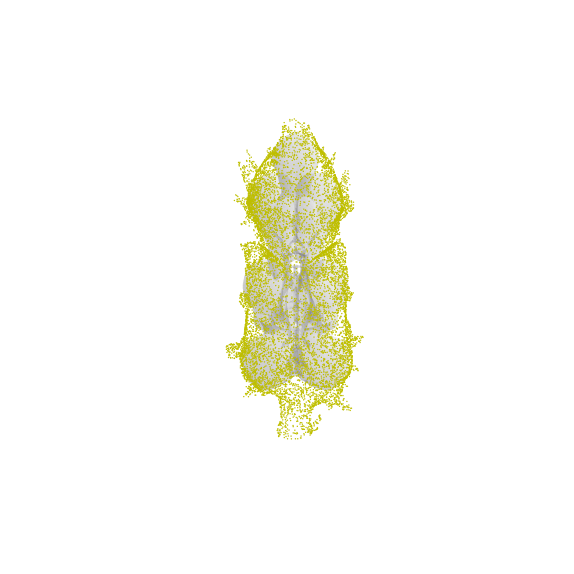

In [17]:
import trimesh as tm

# I quickly made this mesh from the confocal stack
mesh = tm.load('/Users/philipps/Downloads/JRCFIB2018M_cleaned.ply')

fig, ax = navis.plot2d([mesh, mesh_points_xf], scatter_kws=dict(c='y'))
ax.elev = 90

In [10]:
# Looks good to me! Next up: transforming the sample points
sample_mirr_brain = navis.mirror_brain(sample[is_brain], template="JRCFIB2022M", via="JRC2018M")
sample_mirr_vnc = navis.mirror_brain(sample[is_vnc], template="JRCFIB2022M", via="JRCVNC2018M")


In [ ]:
# This also looks decent
navis.plot3d([brain, vnc, sample_mirr_brain, sample_mirr_vnc])

In [12]:
# Just flipped
sample_flip_brain = navis.mirror_brain(sample[is_brain], template='JRCFIB2022M', warp=False)
sample_flip_vnc = navis.mirror_brain(sample[is_vnc], template='JRCFIB2022M', warp=False)

In [ ]:
# As expected this looks less then ideal
navis.plot3d([brain, vnc, sample_flip_brain, sample_flip_vnc])

In [16]:
# Bring it together
source = pd.DataFrame(np.vstack((sample_flip_brain, sample_flip_vnc)), columns=['x_flip', 'y_flip', 'z_flip']).round().astype(int)
target = pd.DataFrame(np.vstack((sample_mirr_brain, sample_mirr_vnc)), columns=['x_mirr', 'y_mirr', 'z_mirr']).round().astype(int)
lm = pd.concat((source, target), axis=1)
lm.head()

,x_flip,y_flip,z_flip,x_mirr,y_mirr,z_mirr
0,715808,204819,291979,737056,187313,285659
1,715808,234819,261979,738172,217870,254815
2,715808,234819,291979,738247,217895,284638
3,715808,264819,261979,739296,248418,253414
4,715808,264819,291979,739641,248490,282843


In [29]:
lm.to_csv('maleCNS_mirror_landmarks_nm.csv', index=False)